[View in Colaboratory](https://colab.research.google.com/github/sungreong/GAN/blob/master/Conditonal_VAE_KERAS.ipynb)

## https://github.com/nnormandin/Conditional_VAE/blob/master/Conditional_VAE.ipynb

In [0]:
import warnings 
import numpy as np
from keras.layers import Input , Dense , Lambda
from keras.layers.merge import concatenate as concat
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from scipy.misc import imsave
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [0]:
(X_train, Y_train ), (X_test, Y_test) = mnist.load_data()

In [0]:
X_train = X_train.astype("float32") / 255.
X_test = X_test.astype("float32") / 255.

n_pixels = np.prod(X_train.shape[1:]) # 28 ,28  => 784
X_train = X_train.reshape((len(X_train), n_pixels)) # (60000, 784)
X_test = X_test.reshape((len(X_test), n_pixels))

In [86]:
print(np.min(X_train), np.max(X_train) )

(0.0, 1.0)


In [87]:
y_train = to_categorical(Y_train)
y_test =to_categorical(Y_test)

y_train.shape
y_train[0:10]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [88]:
m = 250 # batch_size
n_z = 2 # latent space size
encoder_dim1 = 512
decoder_dim = 512
decoder_out_dim = 784 
active = "relu"
optim = Adam(lr=0.001)

n_x=X_train.shape[1]
n_y =y_train.shape[1]

n_epoch =50
n_y

10

In [89]:
X = Input(shape=(n_x,))
label = Input(shape=(n_y ,))
print(X , label)

(<tf.Tensor 'input_7:0' shape=(?, 784) dtype=float32>, <tf.Tensor 'input_8:0' shape=(?, 10) dtype=float32>)


In [90]:
inputs = concat([X, label])
inputs

<tf.Tensor 'concatenate_8/concat:0' shape=(?, 794) dtype=float32>

In [0]:
encoder_h = Dense(encoder_dim1, activation=active)(inputs)
mu =Dense(n_z , activation="linear")(encoder_h)
log_sigma = Dense(n_z, activation="linear")(encoder_h)


In [92]:
def sample_z(args):
    mu, l_sigma= args
    eps = K.random_normal(shape=(m, n_z), mean=0, stddev=1.) 
    return mu+K.exp(log_sigma /2) *eps ## reparameterization trick

z= Lambda(sample_z, output_shape =(n_z, ))([mu,log_sigma])
z # mu 와 log_sigma 생성 

<tf.Tensor 'lambda_3/add:0' shape=(250, 2) dtype=float32>

In [93]:
zc = concat([z,label])
zc # 

<tf.Tensor 'concatenate_9/concat:0' shape=(250, 12) dtype=float32>

In [94]:
decoder_hidden =Dense(decoder_dim ,activation=active)
decoder_out = Dense(decoder_out_dim ,activation="sigmoid")  ## 0~1 값으로 만들어주기 # 784차원 
h_p = decoder_hidden(zc) # decoder_dim = [250 ,12 ]
outputs = decoder_out(h_p)
outputs

<tf.Tensor 'dense_14/Sigmoid:0' shape=(250, 784) dtype=float32>

![대체 텍스트](https://preview.ibb.co/gruCA8/vae.png)

![대체 텍스트](https://preview.ibb.co/i0ROiT/vae_loss.png)

In [0]:
def vae_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    kl = 0.5 * K.sum( K.exp(log_sigma) + K.square(mu) - 1. - log_sigma, axis=-1) ## log_sigma 라 한 이유  gradient descent 이기 때문에 부호 - 안으로 넣어준다 
    return recon + kl

def KL_loss(y_true, y_pred):
	return(0.5 * K.sum(K.exp(log_sigma) + K.square(mu) - 1. - log_sigma, axis=1))

def recon_loss(y_true, y_pred):
	return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

In [0]:
cvae = Model([X, label] , outputs)  # [(250,784), (250,10) ] (250, 784)
encoder = Model([X, label], mu)  # mu 출력

d_in = Input(shape = (n_z+ n_y, )) # (2 + 10 , )
d_h = decoder_hidden(d_in) 
d_out = decoder_out(d_h) # (250, 784 )
decoder = Model(d_in , d_out)

In [0]:
cvae.compile(optimizer = optim, loss=vae_loss , metrics = [KL_loss, recon_loss])

In [98]:
cvae_hist = cvae.fit([X_train, y_train], X_train, verbose = 1, batch_size= m , 
                     
                     epochs=n_epoch , validation_data = ([X_test, y_test], X_test),
                     
                    callbacks = [EarlyStopping(patience=5)])




Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 10s 172us/step - loss: 199.4319 - KL_loss: 9.4564 - recon_loss: 189.9755 - val_loss: 155.8120 - val_KL_loss: 4.5551 - val_recon_loss: 151.2569
Epoch 2/50
60000/60000 [==============================] - 11s 178us/step - loss: 149.8902 - KL_loss: 4.3668 - recon_loss: 145.5234 - val_loss: 145.1374 - val_KL_loss: 4.3206 - val_recon_loss: 140.8168
Epoch 3/50
27000/60000 [============>.................] - ETA: 5s - loss: 144.7338 - KL_loss: 4.3032 - recon_loss: 140.4306

60000/60000 [==============================] - 11s 178us/step - loss: 143.6737 - KL_loss: 4.2918 - recon_loss: 139.3819 - val_loss: 141.6509 - val_KL_loss: 4.3058 - val_recon_loss: 137.3451
Epoch 4/50
60000/60000 [==============================] - 11s 178us/step - loss: 140.9385 - KL_loss: 4.2691 - recon_loss: 136.6694 - val_loss: 139.6983 - val_KL_loss: 4.1689 - val_recon_loss: 135.5293
Epoch 5/50
50250/60000 [========================>.....] - ETA: 1s - loss: 139.4836 - KL_loss: 4.2668 - recon_loss: 135.2168

60000/60000 [==============================] - 11s 178us/step - loss: 139.2495 - KL_loss: 4.2694 - recon_loss: 134.9801 - val_loss: 138.5497 - val_KL_loss: 4.1270 - val_recon_loss: 134.4228
Epoch 6/50
60000/60000 [==============================] - 11s 176us/step - loss: 138.0985 - KL_loss: 4.2810 - recon_loss: 133.8175 - val_loss: 137.5026 - val_KL_loss: 4.2623 - val_recon_loss: 133.2404
Epoch 7/50
55750/60000 [==========================>...] - ETA: 0s - loss: 137.1976 - KL_loss: 4.2954 - recon_loss: 132.9022

60000/60000 [==============================] - 11s 179us/step - loss: 137.1938 - KL_loss: 4.2919 - recon_loss: 132.9019 - val_loss: 136.9451 - val_KL_loss: 4.2184 - val_recon_loss: 132.7267
Epoch 8/50
60000/60000 [==============================] - 11s 180us/step - loss: 136.4457 - KL_loss: 4.2989 - recon_loss: 132.1468 - val_loss: 136.1718 - val_KL_loss: 4.2953 - val_recon_loss: 131.8766
Epoch 9/50
55250/60000 [==========================>...] - ETA: 0s - loss: 135.8786 - KL_loss: 4.3079 - recon_loss: 131.5707

60000/60000 [==============================] - 11s 180us/step - loss: 135.8396 - KL_loss: 4.3087 - recon_loss: 131.5309 - val_loss: 135.6577 - val_KL_loss: 4.2245 - val_recon_loss: 131.4332
Epoch 10/50
60000/60000 [==============================] - 11s 181us/step - loss: 135.3198 - KL_loss: 4.3304 - recon_loss: 130.9894 - val_loss: 135.2298 - val_KL_loss: 4.3004 - val_recon_loss: 130.9294
Epoch 11/50
55500/60000 [==========================>...] - ETA: 0s - loss: 134.8061 - KL_loss: 4.3454 - recon_loss: 130.4607

60000/60000 [==============================] - 11s 179us/step - loss: 134.8485 - KL_loss: 4.3474 - recon_loss: 130.5011 - val_loss: 134.8828 - val_KL_loss: 4.2653 - val_recon_loss: 130.6174
Epoch 12/50
60000/60000 [==============================] - 11s 181us/step - loss: 134.4751 - KL_loss: 4.3718 - recon_loss: 130.1033 - val_loss: 134.4603 - val_KL_loss: 4.3652 - val_recon_loss: 130.0951
Epoch 13/50
55000/60000 [==========================>...] - ETA: 0s - loss: 134.0939 - KL_loss: 4.3868 - recon_loss: 129.7071

60000/60000 [==============================] - 11s 182us/step - loss: 134.1062 - KL_loss: 4.3866 - recon_loss: 129.7196 - val_loss: 134.1967 - val_KL_loss: 4.2650 - val_recon_loss: 129.9318
Epoch 14/50
60000/60000 [==============================] - 11s 181us/step - loss: 133.7918 - KL_loss: 4.4080 - recon_loss: 129.3838 - val_loss: 133.9853 - val_KL_loss: 4.2474 - val_recon_loss: 129.7379
Epoch 15/50
54000/60000 [==========================>...] - ETA: 1s - loss: 133.5035 - KL_loss: 4.4250 - recon_loss: 129.0785

60000/60000 [==============================] - 11s 181us/step - loss: 133.4794 - KL_loss: 4.4250 - recon_loss: 129.0543 - val_loss: 133.6767 - val_KL_loss: 4.3269 - val_recon_loss: 129.3498
Epoch 16/50
60000/60000 [==============================] - 11s 182us/step - loss: 133.1998 - KL_loss: 4.4334 - recon_loss: 128.7664 - val_loss: 133.4768 - val_KL_loss: 4.4030 - val_recon_loss: 129.0738
Epoch 17/50
54250/60000 [==========================>...] - ETA: 0s - loss: 132.9178 - KL_loss: 4.4501 - recon_loss: 128.4676

60000/60000 [==============================] - 11s 179us/step - loss: 132.9612 - KL_loss: 4.4511 - recon_loss: 128.5101 - val_loss: 133.3232 - val_KL_loss: 4.3969 - val_recon_loss: 128.9263
Epoch 18/50
60000/60000 [==============================] - 11s 178us/step - loss: 132.7362 - KL_loss: 4.4607 - recon_loss: 128.2755 - val_loss: 133.1046 - val_KL_loss: 4.4135 - val_recon_loss: 128.6912
Epoch 19/50
56250/60000 [===========================>..] - ETA: 0s - loss: 132.5649 - KL_loss: 4.4766 - recon_loss: 128.0882

60000/60000 [==============================] - 11s 177us/step - loss: 132.5330 - KL_loss: 4.4807 - recon_loss: 128.0523 - val_loss: 132.8266 - val_KL_loss: 4.5152 - val_recon_loss: 128.3114
Epoch 20/50
60000/60000 [==============================] - 11s 178us/step - loss: 132.3334 - KL_loss: 4.4879 - recon_loss: 127.8455 - val_loss: 132.8509 - val_KL_loss: 4.5391 - val_recon_loss: 128.3118
Epoch 21/50
56750/60000 [===========================>..] - ETA: 0s - loss: 132.2284 - KL_loss: 4.4995 - recon_loss: 127.7289

60000/60000 [==============================] - 11s 178us/step - loss: 132.1461 - KL_loss: 4.5015 - recon_loss: 127.6446 - val_loss: 132.5877 - val_KL_loss: 4.4747 - val_recon_loss: 128.1130
Epoch 22/50
60000/60000 [==============================] - 11s 180us/step - loss: 131.9524 - KL_loss: 4.5233 - recon_loss: 127.4291 - val_loss: 132.4096 - val_KL_loss: 4.3766 - val_recon_loss: 128.0330
Epoch 23/50
55000/60000 [==========================>...] - ETA: 0s - loss: 131.7681 - KL_loss: 4.5413 - recon_loss: 127.2268

60000/60000 [==============================] - 11s 179us/step - loss: 131.7907 - KL_loss: 4.5396 - recon_loss: 127.2511 - val_loss: 132.3524 - val_KL_loss: 4.5077 - val_recon_loss: 127.8448
Epoch 24/50
60000/60000 [==============================] - 11s 178us/step - loss: 131.6372 - KL_loss: 4.5422 - recon_loss: 127.0950 - val_loss: 132.1206 - val_KL_loss: 4.4083 - val_recon_loss: 127.7123
Epoch 25/50
55250/60000 [==========================>...] - ETA: 0s - loss: 131.5125 - KL_loss: 4.5557 - recon_loss: 126.9568

60000/60000 [==============================] - 11s 180us/step - loss: 131.5031 - KL_loss: 4.5584 - recon_loss: 126.9447 - val_loss: 132.1317 - val_KL_loss: 4.5133 - val_recon_loss: 127.6184
Epoch 26/50
60000/60000 [==============================] - 11s 179us/step - loss: 131.3831 - KL_loss: 4.5532 - recon_loss: 126.8299 - val_loss: 131.9496 - val_KL_loss: 4.4532 - val_recon_loss: 127.4964
Epoch 27/50
56500/60000 [===========================>..] - ETA: 0s - loss: 131.2739 - KL_loss: 4.5666 - recon_loss: 126.7073

60000/60000 [==============================] - 11s 180us/step - loss: 131.2169 - KL_loss: 4.5692 - recon_loss: 126.6477 - val_loss: 131.9030 - val_KL_loss: 4.5154 - val_recon_loss: 127.3876
Epoch 28/50
60000/60000 [==============================] - 11s 177us/step - loss: 131.1358 - KL_loss: 4.5861 - recon_loss: 126.5497 - val_loss: 131.8089 - val_KL_loss: 4.4289 - val_recon_loss: 127.3800
Epoch 29/50
57000/60000 [===========================>..] - ETA: 0s - loss: 130.9874 - KL_loss: 4.5894 - recon_loss: 126.3980

60000/60000 [==============================] - 11s 177us/step - loss: 131.0292 - KL_loss: 4.5883 - recon_loss: 126.4408 - val_loss: 131.6943 - val_KL_loss: 4.4304 - val_recon_loss: 127.2638
Epoch 30/50
60000/60000 [==============================] - 11s 176us/step - loss: 130.8924 - KL_loss: 4.6047 - recon_loss: 126.2877 - val_loss: 131.5698 - val_KL_loss: 4.4340 - val_recon_loss: 127.1358
Epoch 31/50
57250/60000 [===========================>..] - ETA: 0s - loss: 130.7882 - KL_loss: 4.6066 - recon_loss: 126.1816

60000/60000 [==============================] - 11s 177us/step - loss: 130.7586 - KL_loss: 4.6058 - recon_loss: 126.1528 - val_loss: 131.5739 - val_KL_loss: 4.6032 - val_recon_loss: 126.9706
Epoch 32/50
60000/60000 [==============================] - 11s 177us/step - loss: 130.6966 - KL_loss: 4.6123 - recon_loss: 126.0843 - val_loss: 131.4896 - val_KL_loss: 4.4546 - val_recon_loss: 127.0351
Epoch 33/50
56750/60000 [===========================>..] - ETA: 0s - loss: 130.5614 - KL_loss: 4.6235 - recon_loss: 125.9379

60000/60000 [==============================] - 11s 179us/step - loss: 130.5929 - KL_loss: 4.6252 - recon_loss: 125.9677 - val_loss: 131.4931 - val_KL_loss: 4.5979 - val_recon_loss: 126.8952
Epoch 34/50
60000/60000 [==============================] - 11s 178us/step - loss: 130.4751 - KL_loss: 4.6220 - recon_loss: 125.8530 - val_loss: 131.3816 - val_KL_loss: 4.5506 - val_recon_loss: 126.8310
Epoch 35/50
57000/60000 [===========================>..] - ETA: 0s - loss: 130.3964 - KL_loss: 4.6435 - recon_loss: 125.7529

60000/60000 [==============================] - 11s 177us/step - loss: 130.4015 - KL_loss: 4.6432 - recon_loss: 125.7583 - val_loss: 131.4301 - val_KL_loss: 4.4933 - val_recon_loss: 126.9369
Epoch 36/50
60000/60000 [==============================] - 11s 178us/step - loss: 130.3288 - KL_loss: 4.6351 - recon_loss: 125.6937 - val_loss: 131.2230 - val_KL_loss: 4.5143 - val_recon_loss: 126.7087
Epoch 37/50
55250/60000 [==========================>...] - ETA: 0s - loss: 130.2227 - KL_loss: 4.6431 - recon_loss: 125.5796

60000/60000 [==============================] - 11s 179us/step - loss: 130.2097 - KL_loss: 4.6429 - recon_loss: 125.5669 - val_loss: 131.1943 - val_KL_loss: 4.5255 - val_recon_loss: 126.6689
Epoch 38/50
60000/60000 [==============================] - 11s 179us/step - loss: 130.1439 - KL_loss: 4.6555 - recon_loss: 125.4884 - val_loss: 131.1396 - val_KL_loss: 4.5648 - val_recon_loss: 126.5748
Epoch 39/50
54500/60000 [==========================>...] - ETA: 0s - loss: 130.0810 - KL_loss: 4.6578 - recon_loss: 125.4232

60000/60000 [==============================] - 11s 180us/step - loss: 130.0662 - KL_loss: 4.6566 - recon_loss: 125.4097 - val_loss: 131.0305 - val_KL_loss: 4.5816 - val_recon_loss: 126.4489
Epoch 40/50
60000/60000 [==============================] - 11s 178us/step - loss: 129.9759 - KL_loss: 4.6630 - recon_loss: 125.3129 - val_loss: 131.0441 - val_KL_loss: 4.6446 - val_recon_loss: 126.3994
Epoch 41/50
55500/60000 [==========================>...] - ETA: 0s - loss: 129.8996 - KL_loss: 4.6762 - recon_loss: 125.2234

60000/60000 [==============================] - 11s 179us/step - loss: 129.9086 - KL_loss: 4.6759 - recon_loss: 125.2327 - val_loss: 130.9265 - val_KL_loss: 4.5873 - val_recon_loss: 126.3392
Epoch 42/50
60000/60000 [==============================] - 11s 178us/step - loss: 129.8806 - KL_loss: 4.6812 - recon_loss: 125.1994 - val_loss: 130.9604 - val_KL_loss: 4.5087 - val_recon_loss: 126.4517
Epoch 43/50
56250/60000 [===========================>..] - ETA: 0s - loss: 129.7735 - KL_loss: 4.6830 - recon_loss: 125.0905

60000/60000 [==============================] - 11s 177us/step - loss: 129.7666 - KL_loss: 4.6827 - recon_loss: 125.0839 - val_loss: 130.9881 - val_KL_loss: 4.5932 - val_recon_loss: 126.3949
Epoch 44/50
60000/60000 [==============================] - 11s 178us/step - loss: 129.7324 - KL_loss: 4.6869 - recon_loss: 125.0455 - val_loss: 130.9596 - val_KL_loss: 4.5850 - val_recon_loss: 126.3746
Epoch 45/50
56250/60000 [===========================>..] - ETA: 0s - loss: 129.6404 - KL_loss: 4.7028 - recon_loss: 124.9376

60000/60000 [==============================] - 11s 178us/step - loss: 129.6641 - KL_loss: 4.7040 - recon_loss: 124.9601 - val_loss: 130.8391 - val_KL_loss: 4.6029 - val_recon_loss: 126.2362
Epoch 46/50
60000/60000 [==============================] - 11s 177us/step - loss: 129.5790 - KL_loss: 4.7056 - recon_loss: 124.8734 - val_loss: 130.9160 - val_KL_loss: 4.5780 - val_recon_loss: 126.3380
Epoch 47/50
56750/60000 [===========================>..] - ETA: 0s - loss: 129.4733 - KL_loss: 4.7148 - recon_loss: 124.7585

60000/60000 [==============================] - 11s 177us/step - loss: 129.5391 - KL_loss: 4.7151 - recon_loss: 124.8241 - val_loss: 130.8181 - val_KL_loss: 4.7810 - val_recon_loss: 126.0371
Epoch 48/50
60000/60000 [==============================] - 11s 177us/step - loss: 129.4738 - KL_loss: 4.7188 - recon_loss: 124.7550 - val_loss: 130.7432 - val_KL_loss: 4.6324 - val_recon_loss: 126.1108
Epoch 49/50
57250/60000 [===========================>..] - ETA: 0s - loss: 129.4308 - KL_loss: 4.7180 - recon_loss: 124.7128

60000/60000 [==============================] - 11s 178us/step - loss: 129.3957 - KL_loss: 4.7190 - recon_loss: 124.6767 - val_loss: 130.8323 - val_KL_loss: 4.6514 - val_recon_loss: 126.1810
Epoch 50/50
60000/60000 [==============================] - 11s 177us/step - loss: 129.4096 - KL_loss: 4.7314 - recon_loss: 124.6782 - val_loss: 130.6965 - val_KL_loss: 4.5940 - val_recon_loss: 126.1024


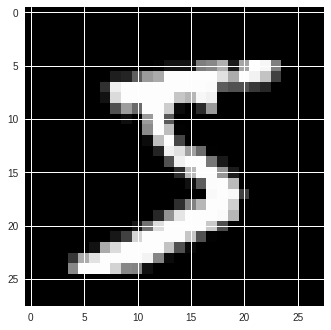

In [99]:
plt.imshow(X_train[0].reshape(28,28), cmap=plt.cm.gray)
plt.show()

In [100]:
print(Y_train[0])

5


In [101]:
encoded_X0 = encoder.predict([X_train[0].reshape((1,784)), y_train[0].reshape((1,10 ))])
print(encoded_X0)

[[-0.12594813  0.39414337]]


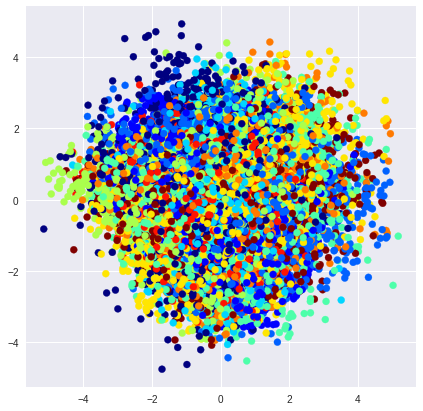

In [107]:
z_train = encoder.predict([X_train, y_train])
encodings= np.asarray(z_train)
encodings = encodings.reshape(X_train.shape[0], n_z)
plt.figure(figsize=(7, 7))
plt.scatter(encodings[:, 0], encodings[:, 1], c=Y_train, cmap=plt.cm.jet)
plt.show()

In [108]:
def construct_numvec(digit, z= None) :
    out = np.zeros((1, n_z +n_y)) # (1,12)
    out[: , digit+n_z ] = 1.
    if z is None :
        return out
    else :
        for i in range(len(z)) :
            out[:, i]=z[i]
        return out

sample_3 = construct_numvec(3,[1/2,1/10])
print(sample_3)

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


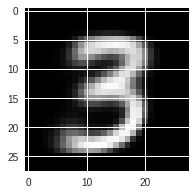

In [109]:
plt.figure(figsize=(3,3))
plt.imshow(decoder.predict(sample_3).reshape(28,28) , cmap = plt.cm.gray )
plt.show()

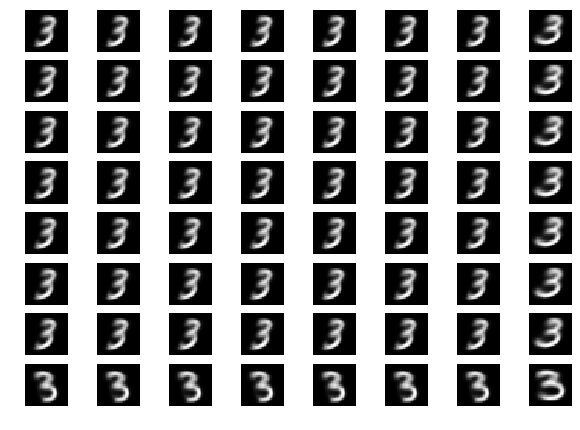

In [110]:
dig = 3
sides = 8
max_z = 1

img_it = 0
for i in range(0, sides):
    z1 = (((i / (sides-1)) * max_z)*2) - max_z
    for j in range(0, sides):
        z2 = (((j / (sides-1)) * max_z)*2) - max_z
        z_ = [z1, z2]
        vec = construct_numvec(dig, z_)
        decoded = decoder.predict(vec)
        plt.subplot(sides, sides, 1 + img_it)
        img_it +=1
        plt.imshow(decoded.reshape(28, 28), cmap = plt.cm.gray)
        plt.axis("off")
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=.2)
plt.show()

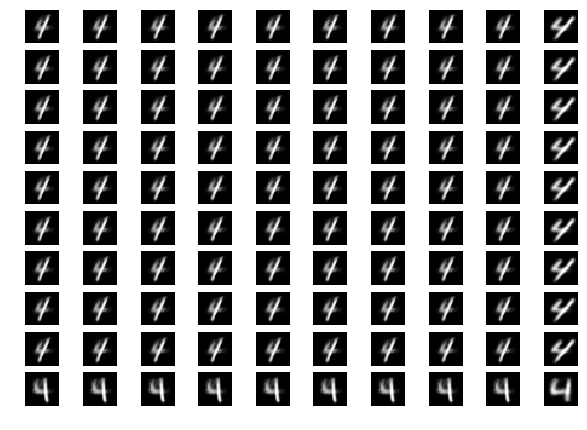

In [122]:
dig = 4
sides = 10
max_z = 1.5

img_it = 0
for i in range(0, sides):
    z1 = (((i / (sides-1)) * max_z)*2) - max_z
    for j in range(0, sides):
        z2 = (((j / (sides-1)) * max_z)*2) - max_z
        z_ = [z1, z2]
        vec = construct_numvec(dig, z_)
        decoded = decoder.predict(vec)
        plt.subplot(sides, sides, 1 + img_it)
        img_it +=1
        plt.imshow(decoded.reshape(28, 28), cmap = plt.cm.gray) 
        plt.axis('off')
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=.2)
plt.show()